## Toxic Comment Classifier

### Loading Kaggle Data

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [263]:
#nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/shivee/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
train_data=pd.read_csv('data/train.csv')

In [4]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test_data=pd.read_csv('data/test.csv')

In [65]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [66]:
test_labels=pd.read_csv('data/test_labels.csv')

In [67]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [9]:
sample_sub=pd.read_csv('data/sample_submission.csv')

In [10]:
sample_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


### Exploratory Data Analysis

In [11]:
train_data.isnull().any(axis=1)
0

0

In [12]:
train_data.isna().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [13]:
train_data[train_data.comment_text==""]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


There seems to be no null values and no NA values in data. Moreover there is no empty comment text.

In [14]:
toxicCnt = sum(train_data.toxic==1)
toxicCnt

15294

In [15]:
severe_toxicCnt=sum(train_data.severe_toxic==1)
severe_toxicCnt

1595

In [16]:
obsceneCnt=sum(train_data.obscene==1)
obsceneCnt

8449

In [17]:
threatCnt=sum(train_data.threat==1)
threatCnt

478

In [18]:
insultCnt=sum(train_data.insult==1)
insultCnt

7877

In [19]:
identity_hateCnt=sum(train_data.identity_hate==1)
identity_hateCnt

1405

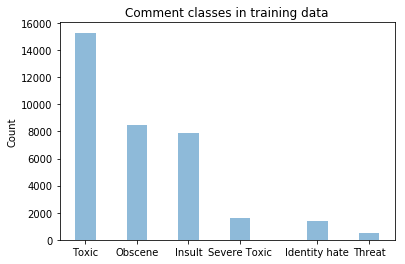

In [172]:
objects = ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity hate', 'Threat')
y_pos = [0,2,4,6,9,11]
occurence = [toxicCnt, obsceneCnt, insultCnt, severe_toxicCnt, identity_hateCnt, threatCnt]
 
plt.bar(y_pos, occurence, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Comment classes in training data')
 
plt.show()

In [68]:
len(train_data), len(test_data)

(159571, 153164)

In [37]:
lens=train_data.comment_text.str.len()
lens.max() , lens.min()

(5000, 6)

In [ ]:
test_labels['toxicReplaced']=test_labels.toxic.replace(-1,0)
#sum(test_labels.toxicReplaced)

### Fit ML models to data

In [249]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string

In [317]:
def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3.
    """
    #Convert everything to lowercase
    text=text.lower()
    # removed punctuation and tabs, new lines
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words=nopunct.split(' ')
    #Lemmatize words
    lmtzr=WordNetLemmatizer()
    words=[lmtzr.lemmatize(w) for w in words]
    # drop words < 2 characters long
    words=[w for w in words if len(w)>2]
    return words


In [318]:
# Convert comments to term-document matrix using TFIDF
vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
            strip_accents='unicode', use_idf=1)
X=vectorizer.fit_transform(train_data.comment_text)
X_test=vectorizer.transform(test_data.comment_text)
X.shape , X_test.shape

((159571, 165006), (153164, 165006))

In [328]:
vectorizer.get_feature_names()[-1000:]

['“rape',
 '“rasgulla',
 '“rashid”',
 '“re',
 '“real',
 '“realised”',
 '“reasons”',
 '“recent”',
 '“reception”',
 '“recognition',
 '“recovered',
 '“recoveret',
 '“red',
 '“refer',
 '“reference',
 '“reform”',
 '“refused',
 '“regarding',
 '“rejection',
 '“related',
 '“relativity”',
 '“reliable',
 '“reliable”',
 '“religion”',
 '“religiosity',
 '“removed',
 '“repeated',
 '“repellention”',
 '“repetition',
 '“report',
 '“report”',
 '“repulsion',
 '“resolved”',
 '“resource',
 '“respect',
 '“reuters',
 '“reverted',
 '“revolutionary',
 '“rick',
 '“rides',
 '“right',
 '“rihanna',
 '“road',
 '“role',
 '“role”',
 '“rootless',
 '“rough',
 '“rumi”',
 '“runners',
 '“russian',
 '“said',
 '“salvador',
 '“sandy”',
 '“santa’s',
 '“satori”',
 '“satuierter',
 '“saturation”',
 '“savage',
 '“save',
 '“saviour”',
 '“saying',
 '“scalopini”',
 '“scheme”',
 '“scholarship”',
 '“school',
 '“schools',
 '“science',
 '“scientifically',
 '“scientific”',
 '“scientists',
 '“scottish',
 '“search',
 '“secondly',
 '“secret

In [319]:
# Creating a Multinomial Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()
# fit the model to classify toxic comments
y=train_data.toxic
clf.fit(X,y)
# Making predictions on test data
prediction_toxic=clf.predict(X_test)

In [320]:
# checking accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
print('Recall' ,recall_score(test_labels.toxicReplaced, prediction_toxic))
print('F1 Score', f1_score(test_labels.toxicReplaced, prediction_toxic))
print('ROC-AUC score', roc_auc_score(test_labels[test_labels.toxic!=-1].toxic, prediction_toxic[test_labels.toxic!=-1]))
print('Accuracy' , accuracy_score(prediction_toxic,test_labels.toxicReplaced))

Recall 0.22545155993431856
F1 Score 0.2119154190461491
ROC-AUC score 0.6107737346382482
Accuracy 0.9333263691206811


In [321]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.toxicReplaced,prediction_toxic)

array([[141579,   5495],
       [  4717,   1373]])

In [322]:
# Creating a Logistic Classifier
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
log_clf.fit(X,y)
prediction_toxic_log= log_clf.predict(X_test)

In [323]:
# checking metrics of logistic classifier

print('Recall' ,recall_score(test_labels[test_labels.toxic!=-1].toxic, prediction_toxic_log[test_labels.toxic!=-1]))
print('F1 Score', f1_score(test_labels[test_labels.toxic!=-1].toxic, prediction_toxic_log[test_labels.toxic!=-1]))
print('ROC-AUC score', roc_auc_score(test_labels[test_labels.toxic!=-1].toxic, prediction_toxic_log[test_labels.toxic!=-1]))
print('Accuracy' , accuracy_score(prediction_toxic_log,test_labels.toxicReplaced))

Recall 0.7014778325123153
F1 Score 0.6766452839154193
ROC-AUC score 0.8311752761234876
Accuracy 0.8508330939385235


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = { 
    
}
gs=GridSearchCV(vectorizer, parameters, n_jobs=-1)


In [ ]:
'''
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)}
'''

#gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
#gs_clf = gs_clf.fit(train_data,train_target)
#gs_clf.best_score_
#gs_clf.best_params_